# Titanic

##### Context
The aim of this project is to predict the survival on the Titanic.

##### Importing

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import linear_model
from sklearn import ensemble
from sklearn import neighbors
from sklearn import svm
from sklearn import tree 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

In [2]:
# import data

train = pd.read_csv("train.csv", index_col="PassengerId")
test = pd.read_csv("test.csv", index_col="PassengerId")
df = pd.concat([train, test])
print("train_shape:", train.shape)
print("test_shape:", test.shape)
df.info()
df.sample(5)

train_shape: (891, 11)
test_shape: (418, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1119,NaN,3,"McNeill, Miss. Bridget",female,NaN,0,0,370368,7.7500,NaN,Q
53,1.0,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
128,1.0,3,"Madsen, Mr. Fridtjof Arne",male,24.0,0,0,C 17369,7.1417,NaN,S
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0000,B28,NaN
501,0.0,3,"Calic, Mr. Petar",male,17.0,0,0,315086,8.6625,NaN,S


##### Pre-processing

In [3]:
# Percentage of missing values in the dataset

print(df.isna().sum())
print("\n","Percentage loading -----")
(df.isna().sum() / df.shape[0]) * 100

# We have a high percentage of missing values for "Cabin" variable. We cannot keep this variable for modelling.
# We are going drop it.
# Variables "Age", "Fare", "Cabin" will be inputed.

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

 Percentage loading -----


Survived    31.932773
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         20.091673
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.076394
Cabin       77.463713
Embarked     0.152788
dtype: float64

In [4]:
# Imputing of "Age" variable
# We are going inpute with the median of the categorie (male, female).
for i in df["Sex"].unique():
    if i == "male":
        df["Age"].fillna(df.groupby("Sex")["Age"].median().loc["male"], inplace=True)
    else:
        df["Age"].fillna(df.groupby("Sex")["Age"].median().loc["female"], inplace=True)

In [5]:
# Removing of "Cabin" variable
df.drop(columns='Cabin', inplace=True)

# removing missing values for "Embarked" variable
df.dropna(subset=["Embarked"], inplace=True)

In [6]:
# Imputation of "Fare" variable

for i in df["Embarked"].unique():
    if i == "S":
        df["Fare"].fillna(df.groupby("Embarked")["Fare"].mean().loc["S"], inplace=True)
    elif i == "C":
        df["Fare"].fillna(df.groupby("Embarked")["Fare"].mean().loc["C"], inplace=True)
    else:
        df["Fare"].fillna(df.groupby("Embarked")["Fare"].mean().loc["Q"], inplace=True)

In [7]:
# Transformation of "Pclass" variable in object type
df["Pclass"] = df["Pclass"].astype("object")

In [8]:
# Extracting title from name 
df["Title"] = df["Name"].str.split(", ",expand=True)[1].str.split(".",expand=True)[0]
df["Title"].value_counts()

Title
Mr              757
Miss            259
Mrs             196
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [9]:
# Replace some modalities by "Other"
df["Title"].replace(["Rev", "Dr", "Col", "Mlle", "Major","Ms", "Lady", "Sir", "Mme",
                     "Don", "Capt", "the Countess", "Jonkheer", "Dona"],"Other", inplace=True)

df["Title"].value_counts()

Title
Mr        757
Miss      259
Mrs       196
Master     61
Other      34
Name: count, dtype: int64

In [10]:
# Family size
# Let's try to know the size of the family at which belong each passenger 
df["Family_size"] = df["SibSp"] + df["Parch"] + 1

In [11]:
def family_range(val):
    if val== 1:
        return "Alone"
    elif val > 1 and val < 5:
        return "Small"
    else:
        return "Large"

df["Family_size"] = df["Family_size"].apply(family_range)

In [12]:
# Removing of useless variable
df.drop(columns=["Name", "Ticket", "SibSp", "Parch"], inplace=True) 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307 entries, 1 to 1309
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     889 non-null    float64
 1   Pclass       1307 non-null   object 
 2   Sex          1307 non-null   object 
 3   Age          1307 non-null   float64
 4   Fare         1307 non-null   float64
 5   Embarked     1307 non-null   object 
 6   Title        1307 non-null   object 
 7   Family_size  1307 non-null   object 
dtypes: float64(3), object(5)
memory usage: 91.9+ KB


In [14]:
df.sample(7)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Family_size
PassengerId,,,,,,,,
1180,NaN,3,male,28.0,7.2292,C,Mr,Alone
967,NaN,1,male,32.5,211.5000,C,Mr,Alone
103,0.0,1,male,21.0,77.2875,S,Mr,Small
360,1.0,3,female,28.0,7.8792,Q,Miss,Alone
720,0.0,3,male,33.0,7.7750,S,Mr,Alone
740,0.0,3,male,28.0,7.8958,S,Mr,Alone
125,0.0,1,male,54.0,77.2875,S,Mr,Small


##### Visualization

In [15]:
# Statistic summarize
df.drop(columns="Survived").describe()

,Age,Fare
count,1307.000000,1307.000000
mean,29.471821,33.219515
std,12.881592,51.746413
min,0.170000,0.000000
25%,22.000000,7.895800
50%,28.000000,14.454200
75%,35.000000,31.275000
max,80.000000,512.329200


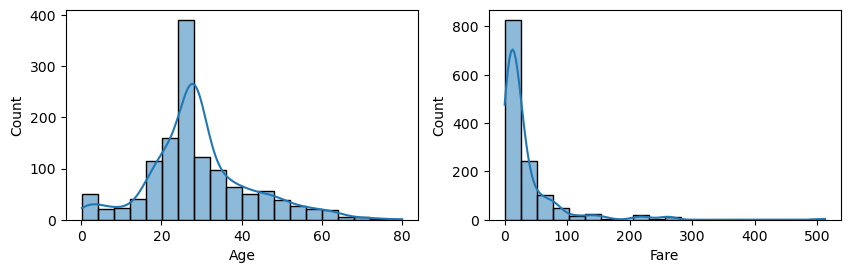

In [16]:
# Histogram
plt.figure(figsize=(10,6))
var = df.drop(columns="Survived").select_dtypes("number").columns
for i, j in enumerate(var, 1):
    plt.subplot(2,2,i)
    sns.histplot(df[j], kde=True, bins=20)
    plt.xlabel(j)
    plt.ylabel("Count")

Text(0.5, 1.0, 'Proportion of males and females on the Titanic')

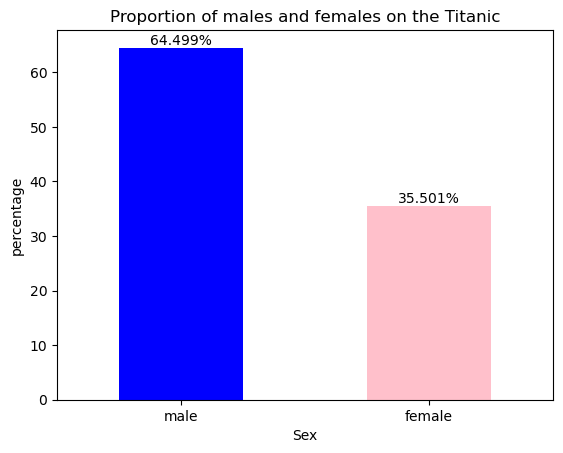

In [17]:
# Proportion of males and females on the titanic
ax = (df["Sex"].value_counts(normalize=True)*100).plot(kind="bar",color=["blue","pink"])
ax.bar_label(ax.containers[0], fmt='%.3f%%')
ax.set_xticklabels(['male', 'female'],rotation=0)
plt.ylabel("percentage")
plt.xlabel("Sex")
plt.title("Proportion of males and females on the Titanic")

Text(0.5, 1.0, 'Proportion of survival on the titanic')

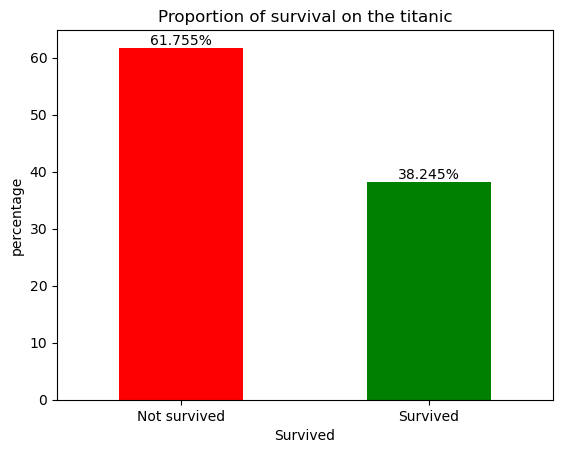

In [18]:
# Proportion of survival on the titanic
ax = (df["Survived"].value_counts(normalize=True)*100).plot(kind="bar", color = ["red", "green"])
ax.bar_label(ax.containers[0], fmt="%.3f%%")
ax.set_xticklabels(['Not survived', 'Survived'], rotation=0)
plt.ylabel("percentage")
plt.title("Proportion of survival on the titanic")

# Based on the part of the information (train set) that we have for the moment, we assumed that around
# 61.75% of people present on the titanic did not survived against 38.245% who did.


Text(0.5, 1.0, 'Comparison between age based on the survival')

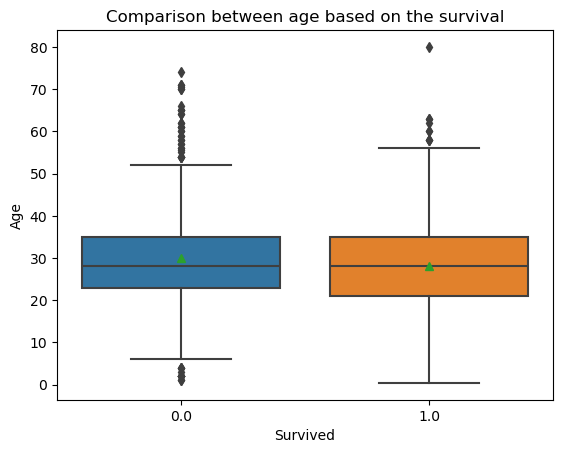

In [19]:
# Boxplot
sns.boxplot(x=df["Survived"], y=df["Age"], showmeans=True)
plt.title("Comparison between age based on the survival")

# This picture shows a comparison between age of survived people and those don't. Interesting fact is
# that the mean is almost equal for each category.

Text(0.5, 1.0, 'Comparison between Fares based on Embarkation point')

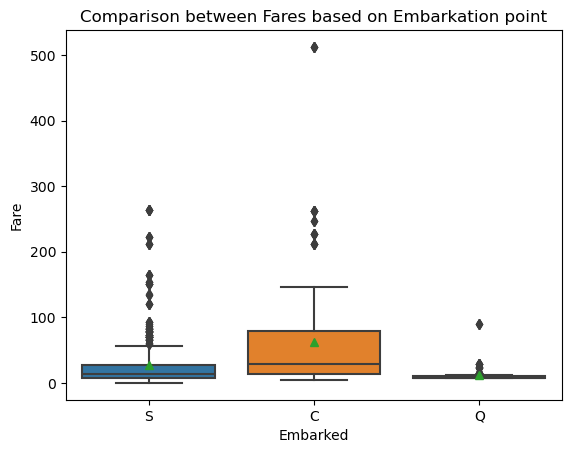

In [20]:
# Boxplot
sns.boxplot(x=df["Embarked"], y=df["Fare"], showmeans = True)
plt.title("Comparison between Fares based on Embarkation point")

# This picture shows a comparison between Fares based on the embarkation point. We noticed that people
# from embarkation point C paid in mean more than people from others embarkation point. We deduced that 
# embarkation point C is a rich place.

Survived  0.0  1.0
Embarked          
C          75   93
Q          47   30
S         427  217
--------
Survived        0.0        1.0
Embarked                      
C         44.642857  55.357143
Q         61.038961  38.961039
S         66.304348  33.695652


Text(0.5, 1.0, 'Percentage of survival based on the embarkation point')

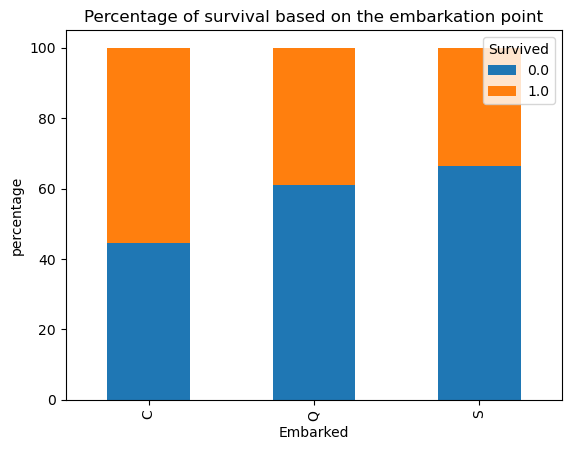

In [21]:
# Contingency table (survival based on the embarkation point)
print(pd.crosstab(df["Embarked"], df["Survived"]))
print("--------")
table = pd.crosstab(df["Embarked"], df["Survived"], normalize="index") * 100
print(table)
table.plot(kind='bar', stacked=True)
plt.ylabel("percentage")
plt.title("Percentage of survival based on the embarkation point")

#  Based on the information that we have for the moment, stats shows that survival based on the 
# embarkation point gives an advantage to embarkation point C. Let's perform statistical tests to be sure 
# of that.

In [22]:
# Definition of a function for running the proportion test
def comparison_proportion(count1, count2, nobs1, nobs2):
    """
    Compare the proportions of two groups using the p-value.

    Parameters:
    count1 (int): Number of successes in the first group.
    nobs1 (int): Total number of observations in the first group.
    count2 (int): Number of successes in the second group.
    nobs2 (int): Total number of observations in the second group.

    Returns:
    p-value of the z-test.
    """
    import statsmodels.api as sm
    count = [count1, count2]
    nobs = [nobs1, nobs2]
    statz, pval = sm.stats.proportions_ztest(count, nobs, alternative='smaller')
    
    return pval


In [23]:
# Hypothesis tests

# Let's do a proportion test in order to see if the difference between survival proportion is significative 
# Let P1 the survival proportion for embarkation point C 
# Let P2 the survival proportion for embarkation point Q 
# Let P3 the survival proportion for embarkation point S
# 
# 1st Hypothesis: 
# H0: P1=P2 vs H1: P1 > P2
print("1st hyp",comparison_proportion(93,30,(93+75),(30+47)))

# p-value > 0.05, then survival proportion of the embarkation point C is not greater than those of the
# point Q. We are in all cases except those where P1 > P2.

# 2nd Hypothesis:
# H0: P1=P3 vs H1: P1 > P3
print("2nd hyp",comparison_proportion(93,217,(93+75),(217+427)))
# p-value > 0.05, then survival proportion of the embarkation point C is not greater than those of the
# point S. We are in all cases except those where P1 > P3.

# 3rd Hypothesis:
# H0: P2=P1 vs H1: P2 > P1
print("3rd hyp",comparison_proportion(30,93,(30+47),(93+75)))
# p-value < 0.05, then survival proportion of the embarkation point Q is greater than those of the 
# point C.

# 4th hypothesis:
# H0: P3=P2 vs H1: P3 > P2
print("4th hyp",comparison_proportion(217,30,(217+427),(30+47)))
# p-value > 0.05, then survival proportion of the embarkation point S is not greater than those of the
# point Q. We are in all cases except those where P3 > P2.

# 5th hypothesis:
# H0: P2=P3 vs H1: P2 > P3
print("5th hyp",comparison_proportion(30,217,(30+47),(217+427)))
# p-value > 0.05, then survival proportion of the embarkation point Q is not greater than those of the
# point S. We are in all cases except those where P2 > P3. Based on the 4th and 5th hypotheses we conclude
# survival proportion of the embarkation point Q and survival proportion of the embarkation point S are the
# same

# Hence (S,Q) > C

1st hyp 0.9914097035993951
2nd hyp 0.9999998674654397
3rd hyp 0.008590296400604963
4th hyp 0.17875276328443312
5th hyp 0.8212472367155669


Survived  0.0  1.0
Pclass            
1          80  134
2          97   87
3         372  119
--------
Survived        0.0        1.0
Pclass                        
1         37.383178  62.616822
2         52.717391  47.282609
3         75.763747  24.236253


Text(0.5, 1.0, 'Percentage of survival based on the ticket class')

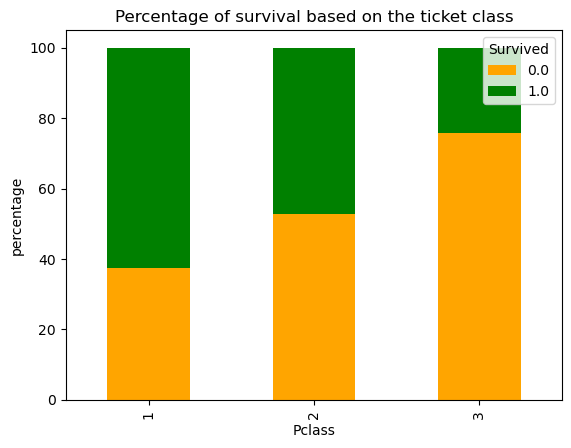

In [24]:
# Contingency table (survival based on the ticket class)
print(pd.crosstab(df["Pclass"], df["Survived"]))
print("--------")
table = pd.crosstab(df["Pclass"], df["Survived"], normalize="index") * 100
print(table)
table.plot(kind='bar', stacked=True, color=["orange", "green"])
plt.ylabel("percentage")
plt.title("Percentage of survival based on the ticket class")

# Stats shows that survival based on the ticket class gives an advantage to first class ticket. Those who 
# paid more have augmented their survival chance. Let's perform statistical tests to be sure of that.

In [25]:
# Hypothesis tests

# Let's do a proportion test in order to see if the difference between survival proportion is significative 
# Let P1 the survival proportion on 1st Pclass
# Let P2 the survival proportion on 2nd Pclass 
# Let P3 the survival proportion on 3rd Pclass
# 
# 1st Hypothesis: 
# H0: P1=P2 vs H1: P1 > P2
print("1st hyp",comparison_proportion(134,87,(134+80),(87+97)))
# p-value > 0.05, then survival proportionon on the 1st Pclass is not greater than those on the 2nd Pclass.
# We are in all cases except those where P1 > P2.


# 2nd Hypothesis:
# H0: P2=P1 vs H1: P2 > P1
print("2nd hyp",comparison_proportion(87,134,(87+97),(134+80)))
# p-value < 0.05, then survival proportion on the 2nd Pclass is greater than those on the 1st Pclass.


# 3rd Hypothesis:
# H0: P2=P3 vs H1: P2 > P3
print("3rd hyp",comparison_proportion(87,119,(87+97),(119+372)))
# p-value > 0.05, then survival proportion on the 2nd Pclass is not greater than those on the 3rd Pclass.
# We are in all cases except those where P2 > P3.


# 4th hypothesis:
# H0: P3=P2 vs H1: P3 > P2
print("4th hyp",comparison_proportion(119,87,(119+372),(87+97)))
# p-value < 0.05, then survival proportion on the 3rd Pclass is greater than those on the 2nd Pclass.

# Then P2 > P1 & P3 > P2 

# Hence P3 > (P1,P2). Survival based on the ticket class gives an advantage to third class ticket.

1st hyp 0.9989271121139408
2nd hyp 0.0010728878860591703
3rd hyp 0.999999996482136
4th hyp 3.517863958820269e-09


##### Modelling

In [26]:
# Train and Test sets
Train = df[~df["Survived"].isna()]
Test = df[df["Survived"].isna()]
Test.drop(columns="Survived", inplace=True)
df = Train # Rename Train in df

print("train_shape:", df.shape)
print("test_shape:", Test.shape)

train_shape: (889, 8)
test_shape: (418, 7)


Text(0.5, 1.0, 'Heatmap of correlations')

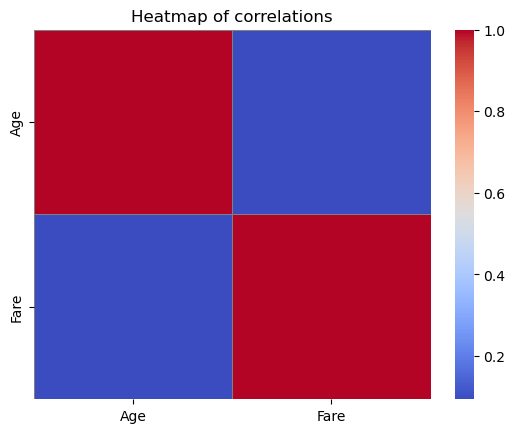

In [27]:
# Checking of colinearity
cor_table = df.select_dtypes('number').drop(columns="Survived").corr()
sns.heatmap(cor_table, cmap="coolwarm", linewidths=0.5, linecolor='gray')
plt.title("Heatmap of correlations")

# There is not multicolinearity between explanatory variables

In [28]:
# Cut dataset in train and test sets
target = "Survived"
X = df.drop(columns=target)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_shape:",X.shape)
print("y_shape:",y.shape)
print("X_train_shape:",X_train.shape)
print("y_train_shape:",y_train.shape)
print("X_test_shape:",X_test.shape)
print("y_test_shape:",y_test.shape)

X_shape: (889, 7)
y_shape: (889,)
X_train_shape: (711, 7)
y_train_shape: (711,)
X_test_shape: (178, 7)
y_test_shape: (178,)


In [29]:
numerical_features = X.select_dtypes('number').columns
categorical_features = X.select_dtypes('object').columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first') # first is used in order to avoid multicolinearity

preprocessor = ColumnTransformer(
    [
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [30]:
# Estimators to use:
Models = [
    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(random_state=42),
    linear_model.RidgeClassifier(),
    linear_model.SGDClassifier(random_state=42),
    # ensemble models
    ensemble.AdaBoostClassifier(random_state=42),
    ensemble.BaggingClassifier(random_state=42),
    ensemble.ExtraTreesClassifier(random_state=42),
    ensemble.GradientBoostingClassifier(random_state=42),
    ensemble.HistGradientBoostingClassifier(random_state=42),
    ensemble.RandomForestClassifier(random_state=42),
    #Tree
    tree.DecisionTreeClassifier(random_state=42),
    tree.ExtraTreeClassifier(random_state=42),
    # SVM
    svm.SVC(),
    #XGBoost
    XGBClassifier(seed=42)
]

In [31]:
# Training of the model
models = []
train_score = []
test_score = []
for i in Models:
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', i)
    ])
    model.fit(X_train, y_train)
    models.append(str(i).split(".")[0])
    train_score.append(model.score(X_train, y_train))
    test_score.append(accuracy_score(y_test, model.predict(X_test)))

In [32]:
# Summary of the performance
model_summary= pd.DataFrame({
    'Model': models,
    'train_score': train_score,
    'test_score': test_score})

model_summary.sort_values(by="test_score", ascending=False, inplace=True)
model_summary

,Model,train_score,test_score
3,SGDClassifier(random_state=42),0.828411,0.831461
7,GradientBoostingClassifier(random_state=42),0.907173,0.831461
0,LogisticRegressionCV(),0.822785,0.825843
2,RidgeClassifier(),0.828411,0.820225
4,AdaBoostClassifier(random_state=42),0.856540,0.820225
12,SVC(),0.855134,0.820225
13,"XGBClassifier(base_score=None, booster=None, c...",0.970464,0.803371
5,BaggingClassifier(random_state=42),0.977496,0.786517
9,RandomForestClassifier(random_state=42),0.987342,0.786517
8,HistGradientBoostingClassifier(random_state=42),0.950774,0.780899


In [33]:
# Selection of the 3 best estimators
# Mod1 = SGDClassifier()

# Mod2 = GradientBoostingClassifier()

# Mod3 = LogisticRegressionCV()

In [34]:
# Tuning of hyperparameters Mod1
Mod1 = Pipeline([
    ('preprocessor',preprocessor),
    ('classifier', linear_model.SGDClassifier(random_state=42))
])

param_grid = {
    'classifier__loss': ['hinge', 'log_loss', 'perceptron'],
    'classifier__eta0': [0.1, 0.2, 0.3],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [1e-4, 1e-3, 1e-2],
    'classifier__learning_rate': ['constant', 'optimal'],
    'classifier__n_jobs': [-1],
    'classifier__tol': [1e-3, 1e-4, 1e-5]
}

model_sgd = GridSearchCV(Mod1, param_grid, cv=5, scoring='accuracy')
model_sgd.fit(X_train, y_train)

print("Best cross-validation score:",model_sgd.best_score_)
print("Best params:", model_sgd.best_params_)
print("test score:", model_sgd.score(X_test, y_test))


Best cross-validation score: 0.832640598837782
Best params: {'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'hinge', 'classifier__n_jobs': -1, 'classifier__penalty': 'elasticnet', 'classifier__tol': 0.001}
test score: 0.8258426966292135


In [35]:
# Tuning of hyperparameters Mod2
Mod2 = Pipeline([
    ('preprocessor',preprocessor),
    ('classifier', ensemble.GradientBoostingClassifier(random_state=42))
])

param_grid = {
    'classifier__loss': ['log_loss','exponential'],
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__min_samples_split': [2,3],
    'classifier__tol': [0.0001, 0.0002, 0.0003],
    'classifier__validation_fraction': [0.1, 0.2, 0.3],
    'classifier__max_depth':[3,5,8]
}

model_gb = GridSearchCV(Mod2, param_grid, cv=5, scoring='accuracy')
model_gb.fit(X_train, y_train)

print("Best cross-validation score:",model_gb.best_score_)
print("Best params:", model_gb.best_params_)
print("test score:", model_gb.score(X_test, y_test))

Best cross-validation score: 0.8396828523589086
Best params: {'classifier__learning_rate': 0.2, 'classifier__loss': 'exponential', 'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'classifier__tol': 0.0001, 'classifier__validation_fraction': 0.1}
test score: 0.8258426966292135


In [36]:
# Tuning of hyperparameters Mod3
Mod3 = Pipeline([
    ('preprocessor',preprocessor),
    ('classifier',linear_model.LogisticRegressionCV())
])

param_grid = {
    'classifier__penalty':['l1','l2','elasticnet'],
    'classifier__solver':['liblinear', 'lbfgs', 'sag', 'saga'],
    'classifier__random_state':[42]
}

model_lr = GridSearchCV(Mod3, param_grid, cv=5, scoring='accuracy')
model_lr.fit(X_train, y_train)

print("Best cross-validation score:",model_lr.best_score_)
print("Best params:", model_lr.best_params_)
print("test score:", model_lr.score(X_test, y_test))

Best cross-validation score: 0.8312026002166848
Best params: {'classifier__penalty': 'l2', 'classifier__random_state': 42, 'classifier__solver': 'liblinear'}
test score: 0.8314606741573034


Among 3 best models choosed, the one that shows best performances after hyperparameters tuning is Mod2. We are going try to predict in order to see if our predictions are good.

Same thing with gradientboosting

In [37]:
# Prediction with gradient boosting classifier
prediction = model_gb.predict(Test)
prediction = prediction.astype(int)
prediction = pd.Series(prediction, name="Survived")
index_s = pd.Series(Test.index, name="PassengerId") # conversion of the index in series for the binding
prediction = pd.concat([index_s, prediction], axis=1)
prediction.to_csv("submission.csv", index=False)

##### Conclusion
Depending on the point of embarkation, a passenger who boarded the Titanic at Queenstown or Southampton is more likely to survive than one who did so at Chelbourg.
Depending on the ticket class, a passenger who paid a third class ticket is more likely to survive than one who paid a second class ticket or first class ticket. Our model that performs better is GradientBoostingClassifier.